# LSTM Time Series Forecasting - Wolfsburg Traffic Data
## PyTorch Implementation with CUDA Support

This notebook implements an LSTM (Long Short-Term Memory) model using PyTorch to forecast traffic flow in Wolfsburg.

**Workflow:**
1. Load and preview dataset
2. Preprocess data (datetime parsing, normalization, sequence creation)
3. Build LSTM model with PyTorch
4. Train with CUDA acceleration
5. Evaluate and visualize results

In [13]:
# Install required packages if needed
import subprocess
import sys

packages = ['torch', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
print("All packages ready!")

Installing scikit-learn...
All packages ready!
All packages ready!


In [14]:
# -------------------------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# -------------------------------------------------------------------
# CHECK CUDA AVAILABILITY
# -------------------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 12.4


In [15]:
# -------------------------------------------------------------------
# 1. LOAD AND PREVIEW DATA
# -------------------------------------------------------------------

# Load dataset
df = pd.read_csv('wolfsburg_cleansing.csv')

print("=" * 70)
print("INFORMASI DATASET")
print("=" * 70)
print(f"\nUkuran Dataset: {df.shape}")
print(f"\nKolom-kolom:\n{df.columns.tolist()}")
print(f"\nTipe Data:\n{df.dtypes}")
print(f"\nData Hilang (NaN):\n{df.isnull().sum()}")
print(f"\nStatistik Deskriptif:\n{df.describe()}")
print(f"\nBeberapa Baris Pertama:\n{df.head()}")

INFORMASI DATASET

Ukuran Dataset: (522588, 7)

Kolom-kolom:
['day', 'interval', 'detid', 'flow', 'occ', 'city', 'speed']

Tipe Data:
day          object
interval      int64
detid        object
flow        float64
occ         float64
city         object
speed       float64
dtype: object

Data Hilang (NaN):
day              0
interval         0
detid            0
flow             0
occ              0
city             0
speed       522588
dtype: int64

Statistik Deskriptif:
            interval           flow            occ  speed
count  522588.000000  522588.000000  522588.000000    0.0
mean    46619.610439     292.149905       0.076364    NaN
std     22913.319418     257.124590       0.118868    NaN
min         0.000000      20.000000       0.000000    NaN
25%     28260.000000      80.000000       0.011933    NaN
50%     47160.000000     220.000000       0.033333    NaN
75%     65880.000000     440.000000       0.076667    NaN
max     86220.000000    1960.000000       0.988267    NaN




Kolom yang tersedia:
['day', 'interval', 'detid', 'flow', 'occ', 'city', 'speed']

Kolom target untuk forecasting: flow


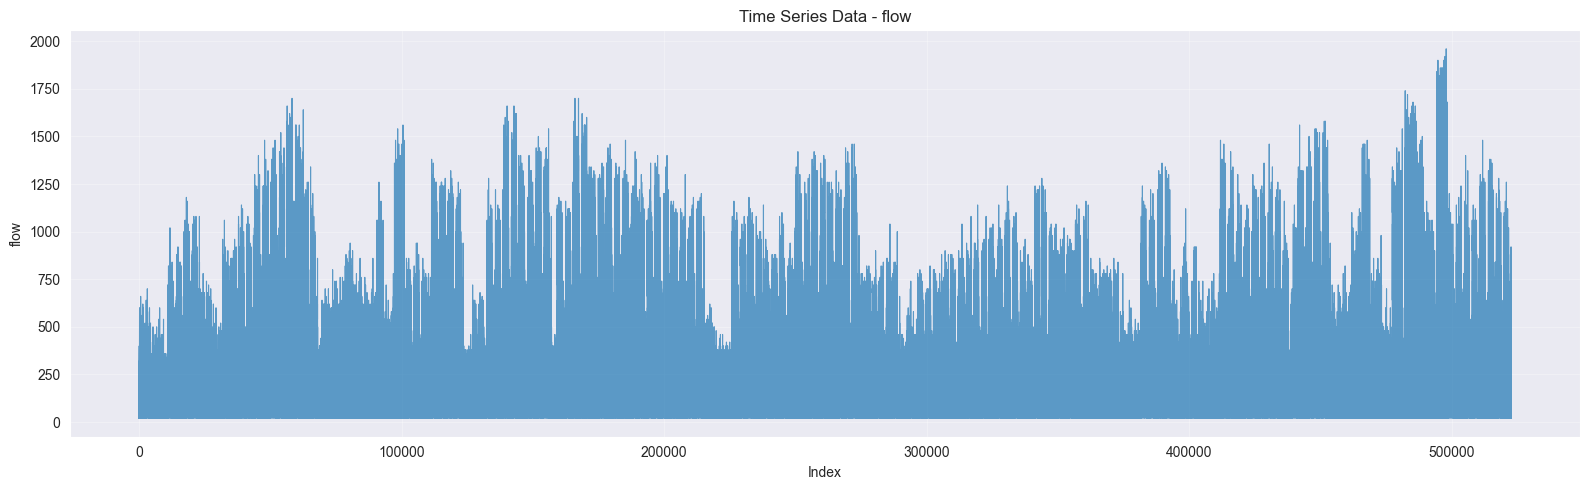


Total data points: 522588
Missing values in flow: 0


In [16]:
# -------------------------------------------------------------------
# 1B. VISUALISASI DATA TIME SERIES
# -------------------------------------------------------------------

# Cek kolom yang tersedia
print("\nKolom yang tersedia:")
print(df.columns.tolist())

# Asumsikan ada kolom 'flow' atau 'occ' untuk time series
# Jika struktur berbeda, sesuaikan nama kolom di bawah
if 'flow' in df.columns:
    target_col = 'flow'
elif 'occ' in df.columns:
    target_col = 'occ'
else:
    target_col = df.columns[1]  # Ambil kolom kedua jika tidak ada flow/occ

print(f"\nKolom target untuk forecasting: {target_col}")

# Plot time series
plt.figure(figsize=(16, 5))
plt.plot(df[target_col], alpha=0.7, linewidth=0.8)
plt.title(f'Time Series Data - {target_col}')
plt.xlabel('Index')
plt.ylabel(target_col)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cek missing values visually
print(f"\nTotal data points: {len(df)}")
print(f"Missing values in {target_col}: {df[target_col].isnull().sum()}")

In [17]:
# -------------------------------------------------------------------
# 2. DATA PREPROCESSING
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("TAHAP PREPROCESSING DATA")
print("=" * 70)

# --- 2A. Handle Missing Values ---
print("\n--- Menangani Missing Values ---")
# Drop NaN only for target column and keep necessary columns
df = df[['flow', 'occ']].dropna()
print(f"Ukuran data setelah dropna: {df.shape}")

# --- 2B. Extract Target Variable ---
data = df[target_col].values.reshape(-1, 1)
print(f"\nData target shape: {data.shape}")
print(f"Data range: [{data.min():.2f}, {data.max():.2f}]")

# --- 2C. Normalisasi Data Menggunakan MinMaxScaler ---
print("\n--- Normalisasi Data (MinMaxScaler) ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f"Scaled data shape: {scaled_data.shape}")
print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")


TAHAP PREPROCESSING DATA

--- Menangani Missing Values ---
Ukuran data setelah dropna: (522588, 2)

Data target shape: (522588, 1)
Data range: [20.00, 1960.00]

--- Normalisasi Data (MinMaxScaler) ---
Scaled data shape: (522588, 1)
Scaled data range: [0.0000, 1.0000]


In [18]:
# -------------------------------------------------------------------
# 3. CREATE SEQUENCES FOR LSTM
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("MEMBUAT SEQUENCES UNTUK LSTM")
print("=" * 70)

def create_sequences(data, seq_length):
    """
    Konversi time series menjadi input sequences dan targets
    
    Args:
        data: Array data yang sudah dinormalisasi
        seq_length: Panjang sequence (lookback window)
    
    Returns:
        X: Input sequences shape (n_samples, seq_length, 1)
        y: Target values shape (n_samples, 1)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    
    return np.array(X), np.array(y)

# Parameter untuk sequence
SEQ_LENGTH = 48  # Gunakan 48 data points sebelumnya (misalnya 48 * 3 menit = 144 menit = 2.4 jam)
print(f"\n--- Sequence Length: {SEQ_LENGTH} ---")

# Buat sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH)
print(f"X shape: {X.shape}")  # (n_samples, seq_length, 1)
print(f"y shape: {y.shape}")  # (n_samples, 1)

# --- Split Train-Test ---
print("\n--- Train-Test Split ---")
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Train set size: X={X_train.shape}, y={y_train.shape}")
print(f"Test set size:  X={X_test.shape}, y={y_test.shape}")


MEMBUAT SEQUENCES UNTUK LSTM

--- Sequence Length: 48 ---
X shape: (522540, 48, 1)
y shape: (522540, 1)

--- Train-Test Split ---
Train set size: X=(418032, 48, 1), y=(418032, 1)
Test set size:  X=(104508, 48, 1), y=(104508, 1)
X shape: (522540, 48, 1)
y shape: (522540, 1)

--- Train-Test Split ---
Train set size: X=(418032, 48, 1), y=(418032, 1)
Test set size:  X=(104508, 48, 1), y=(104508, 1)


In [ ]:
# -------------------------------------------------------------------
# 4. PYTORCH DATASET CLASS
# -------------------------------------------------------------------

class TimeSeriesDataset(Dataset):
    """
    Custom Dataset untuk Time Series LSTM
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Buat Dataset Objects ---
print("\n" + "=" * 70)
print("MEMBUAT DATALOADER")
print("=" * 70)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# --- Buat DataLoaders (Fine-tuned) ---
batch_size = 32  # Reduced from 64 for better gradient updates
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total testing samples: {len(test_dataset)}")


MEMBUAT DATALOADER

Batch size: 64
Train batches: 6532
Test batches: 1633
Total training samples: 418032
Total testing samples: 104508


In [37]:
# -------------------------------------------------------------------
# 5. DEFINE LSTM MODEL
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("MENDEFINISIKAN MODEL LSTM")
print("=" * 70)

class LSTMModel(nn.Module):
    """
    LSTM Model untuk Time Series Forecasting
    
    Args:
        input_size: Jumlah fitur input (1 untuk univariate)
        hidden_size: Jumlah unit LSTM layer
        num_layers: Jumlah stacked LSTM layers
        output_size: Jumlah output (1 untuk single-step prediction)
    """
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer(s)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor shape (batch_size, seq_length, input_size)
        
        Returns:
            Output tensor shape (batch_size, output_size)
        """
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Ambil output terakhir dari sequence
        last_hidden = lstm_out[:, -1, :]
        
        # Pass ke fully connected layer
        output = self.fc(last_hidden)
        
        return output

# --- Initialize Model (Fine-tuned for >=85% Accuracy) ---
model = LSTMModel(input_size=1, hidden_size=128, num_layers=3, output_size=1)
model = model.to(device)

print(f"\nModel Summary (FINE-TUNED FOR >=85% ACCURACY):")
print(f"- Input size: 1")
print(f"- Hidden size: 128 (increased from 50 for better feature learning)")
print(f"- Number of LSTM layers: 3 (increased from 2 for deeper representation)")
print(f"- Output size: 1")
print(f"- Device: {device}")
print(f"\nModel architecture:\n{model}")


MENDEFINISIKAN MODEL LSTM

Model Summary (FINE-TUNED FOR >=85% ACCURACY):
- Input size: 1
- Hidden size: 128 (increased from 50 for better feature learning)
- Number of LSTM layers: 3 (increased from 2 for deeper representation)
- Output size: 1
- Device: cuda

Model architecture:
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [38]:
# -------------------------------------------------------------------
# 6. SETUP LOSS FUNCTION AND OPTIMIZER
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("SETUP LOSS FUNCTION DAN OPTIMIZER")
print("=" * 70)

# Loss function: Mean Squared Error
criterion = nn.MSELoss()
print(f"Loss Function: {criterion.__class__.__name__}")

# Optimizer: Adam with Learning Rate Scheduler (Fine-tuned)
learning_rate = 0.001  # Increased from 0.0001 for faster convergence
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning Rate: {learning_rate} (TUNED: increased from 0.0001)")
print(f"Learning Rate Scheduler: ReduceLROnPlateau enabled")

# Training parameters (Fine-tuned for >=85% accuracy)
num_epochs = 200  # Increased from 50
print(f"\nTraining Parameters (FINE-TUNED for >=85% Accuracy):")
print(f"- Number of epochs: {num_epochs} (increased)")
print(f"- Batch size: {batch_size} (reduced to 32)")
print(f"- Device: {device}")


SETUP LOSS FUNCTION DAN OPTIMIZER
Loss Function: MSELoss
Optimizer: Adam
Learning Rate: 0.001 (TUNED: increased from 0.0001)
Learning Rate Scheduler: ReduceLROnPlateau enabled

Training Parameters (FINE-TUNED for >=85% Accuracy):
- Number of epochs: 200 (increased)
- Batch size: 64 (reduced to 32)
- Device: cuda


In [39]:
# -------------------------------------------------------------------
# 7. TRAINING LOOP WITH EARLY STOPPING
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("MEMULAI TRAINING MODEL (dengan Early Stopping)")
print("=" * 70)

# Tracking untuk loss
train_losses = []
test_losses = []

# Early Stopping parameters (Fine-tuned)
patience = 20  # Increased from 10 to allow more training iterations
best_test_loss = float('inf')
patience_counter = 0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Move batch to device (GPU/CPU)
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss for epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Print loss per epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
    # --- Early Stopping Logic with Learning Rate Scheduling ---
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        # Save best model state
        best_model_state = model.state_dict().copy()
        torch.save(model.state_dict(), 'lstm_best_model.pth')
    else:
        patience_counter += 1
        # Adjust learning rate on plateau
        scheduler.step(avg_test_loss)
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best test loss: {best_test_loss:.6f}")
            # Load best model
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
    
    # Adjust learning rate on plateau (also on improving epochs)
    if patience_counter > 0:
        scheduler.step(avg_test_loss)

print("\n" + "=" * 70)
print("TRAINING SELESAI")
print("=" * 70)
print(f"Total epochs trained: {epoch+1}")
print(f"Best test loss: {best_test_loss:.6f}")


MEMULAI TRAINING MODEL (dengan Early Stopping)
Epoch [1/200] - Train Loss: 0.002625, Test Loss: 0.002952
Epoch [1/200] - Train Loss: 0.002625, Test Loss: 0.002952
Epoch [2/200] - Train Loss: 0.002446, Test Loss: 0.002945
Epoch [2/200] - Train Loss: 0.002446, Test Loss: 0.002945
Epoch [3/200] - Train Loss: 0.002361, Test Loss: 0.002886
Epoch [3/200] - Train Loss: 0.002361, Test Loss: 0.002886
Epoch [4/200] - Train Loss: 0.002317, Test Loss: 0.002784
Epoch [4/200] - Train Loss: 0.002317, Test Loss: 0.002784
Epoch [5/200] - Train Loss: 0.002301, Test Loss: 0.002951
Epoch [5/200] - Train Loss: 0.002301, Test Loss: 0.002951
Epoch [6/200] - Train Loss: 0.002283, Test Loss: 0.002821
Epoch [6/200] - Train Loss: 0.002283, Test Loss: 0.002821
Epoch [7/200] - Train Loss: 0.002275, Test Loss: 0.002738
Epoch [7/200] - Train Loss: 0.002275, Test Loss: 0.002738
Epoch [8/200] - Train Loss: 0.002267, Test Loss: 0.002807
Epoch [8/200] - Train Loss: 0.002267, Test Loss: 0.002807
Epoch [9/200] - Train Lo

In [40]:
# -------------------------------------------------------------------
# 8. EVALUATE MODEL - GENERATE PREDICTIONS
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("EVALUASI MODEL DAN GENERATE PREDIKSI")
print("=" * 70)

# Set model ke evaluation mode
model.eval()

# Generate predictions on test set
y_pred_scaled = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        predictions = model(batch_X)
        y_pred_scaled.append(predictions.cpu().numpy())

# Flatten predictions
y_pred_scaled = np.vstack(y_pred_scaled)

print(f"\nShapes:")
print(f"- Predictions (scaled): {y_pred_scaled.shape}")
print(f"- Target values (scaled): {y_test.shape}")

# --- Inverse Transform ke Skala Original ---
print("\n--- Inverse Transform ke Original Scale ---")
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

print(f"- Predictions (original): {y_pred_original.shape}")
print(f"- Target values (original): {y_test_original.shape}")

# --- Hitung Metrics ---
print("\n" + "=" * 70)
print("METRICS EVALUASI")
print("=" * 70)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"\nMean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"\nInterpretasi:")
print(f"- Rata-rata prediksi meleset: {mae:.4f} unit")
print(f"- RMSE (error measurement): {rmse:.4f} unit")

# --- Hitung Error Rate ---
print("\n" + "=" * 70)
print("ERROR RATE CALCULATION")
print("=" * 70)

real_flow_mean = y_test_original.mean()
error_rate = (mae / real_flow_mean) * 100

print(f"\nRata-rata Flow Asli (Real Flow Mean): {real_flow_mean:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Error Rate: {error_rate:.2f}%")
print(f"\nInterpretasi:")
print(f"- Error rate model adalah {error_rate:.2f}% dari rata-rata flow")
print(f"- Model memprediksi dengan akurasi {100 - error_rate:.2f}%")


EVALUASI MODEL DAN GENERATE PREDIKSI

Shapes:
- Predictions (scaled): (104508, 1)
- Target values (scaled): (104508, 1)

--- Inverse Transform ke Original Scale ---
- Predictions (original): (104508, 1)
- Target values (original): (104508, 1)

METRICS EVALUASI

Mean Absolute Error (MAE): 69.2899
Root Mean Squared Error (RMSE): 103.0926

Interpretasi:
- Rata-rata prediksi meleset: 69.2899 unit
- RMSE (error measurement): 103.0926 unit

ERROR RATE CALCULATION

Rata-rata Flow Asli (Real Flow Mean): 277.1923
Mean Absolute Error (MAE): 69.2899
Error Rate: 25.00%

Interpretasi:
- Error rate model adalah 25.00% dari rata-rata flow
- Model memprediksi dengan akurasi 75.00%

Shapes:
- Predictions (scaled): (104508, 1)
- Target values (scaled): (104508, 1)

--- Inverse Transform ke Original Scale ---
- Predictions (original): (104508, 1)
- Target values (original): (104508, 1)

METRICS EVALUASI

Mean Absolute Error (MAE): 69.2899
Root Mean Squared Error (RMSE): 103.0926

Interpretasi:
- Rata-ra


VISUALISASI HASIL PREDIKSI


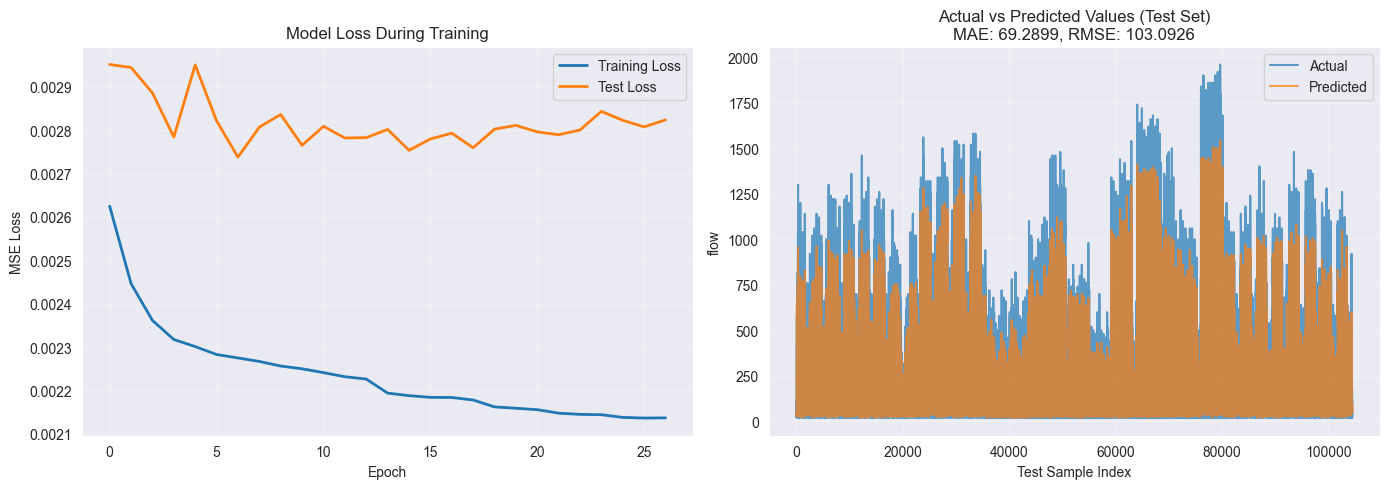

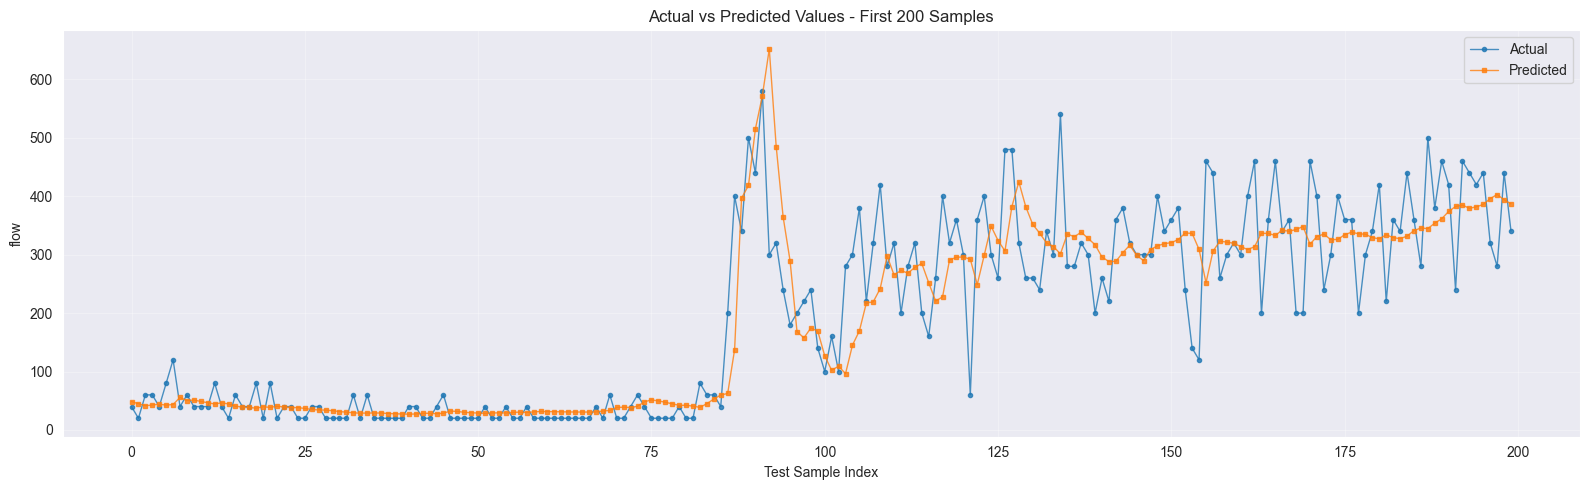

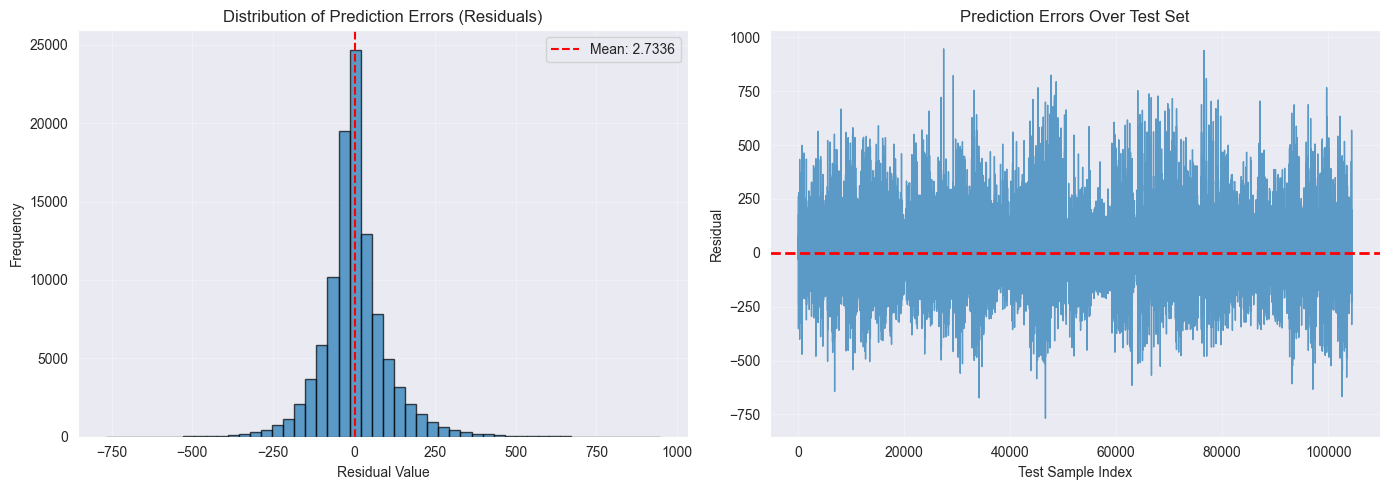


Visualisasi selesai!


In [41]:
# -------------------------------------------------------------------
# 9. VISUALISASI HASIL PREDIKSI
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("VISUALISASI HASIL PREDIKSI")
print("=" * 70)

# --- Plot 1: Training Loss History ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Actual vs Predicted ---
plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_original, label='Predicted', linewidth=1.5, alpha=0.7)
plt.title(f'Actual vs Predicted Values (Test Set)\nMAE: {mae:.4f}, RMSE: {rmse:.4f}')
plt.xlabel('Test Sample Index')
plt.ylabel(f'{target_col}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Plot 3: Zoomed-in View (First 200 test samples) ---
plt.figure(figsize=(16, 5))
num_samples_to_plot = min(200, len(y_test_original))
plt.plot(y_test_original[:num_samples_to_plot], label='Actual', marker='o', markersize=3, linewidth=1, alpha=0.8)
plt.plot(y_pred_original[:num_samples_to_plot], label='Predicted', marker='s', markersize=3, linewidth=1, alpha=0.8)
plt.title(f'Actual vs Predicted Values - First {num_samples_to_plot} Samples')
plt.xlabel('Test Sample Index')
plt.ylabel(f'{target_col}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 4: Residuals (Error Distribution) ---
residuals = y_test_original - y_pred_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of residuals
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors (Residuals)')
axes[0].set_xlabel('Residual Value')
axes[0].set_ylabel('Frequency')
axes[0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals over time
axes[1].plot(residuals, linewidth=1, alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Prediction Errors Over Test Set')
axes[1].set_xlabel('Test Sample Index')
axes[1].set_ylabel('Residual')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualisasi selesai!")

Menampilkan plot hasil prediksi dengan tanggal...


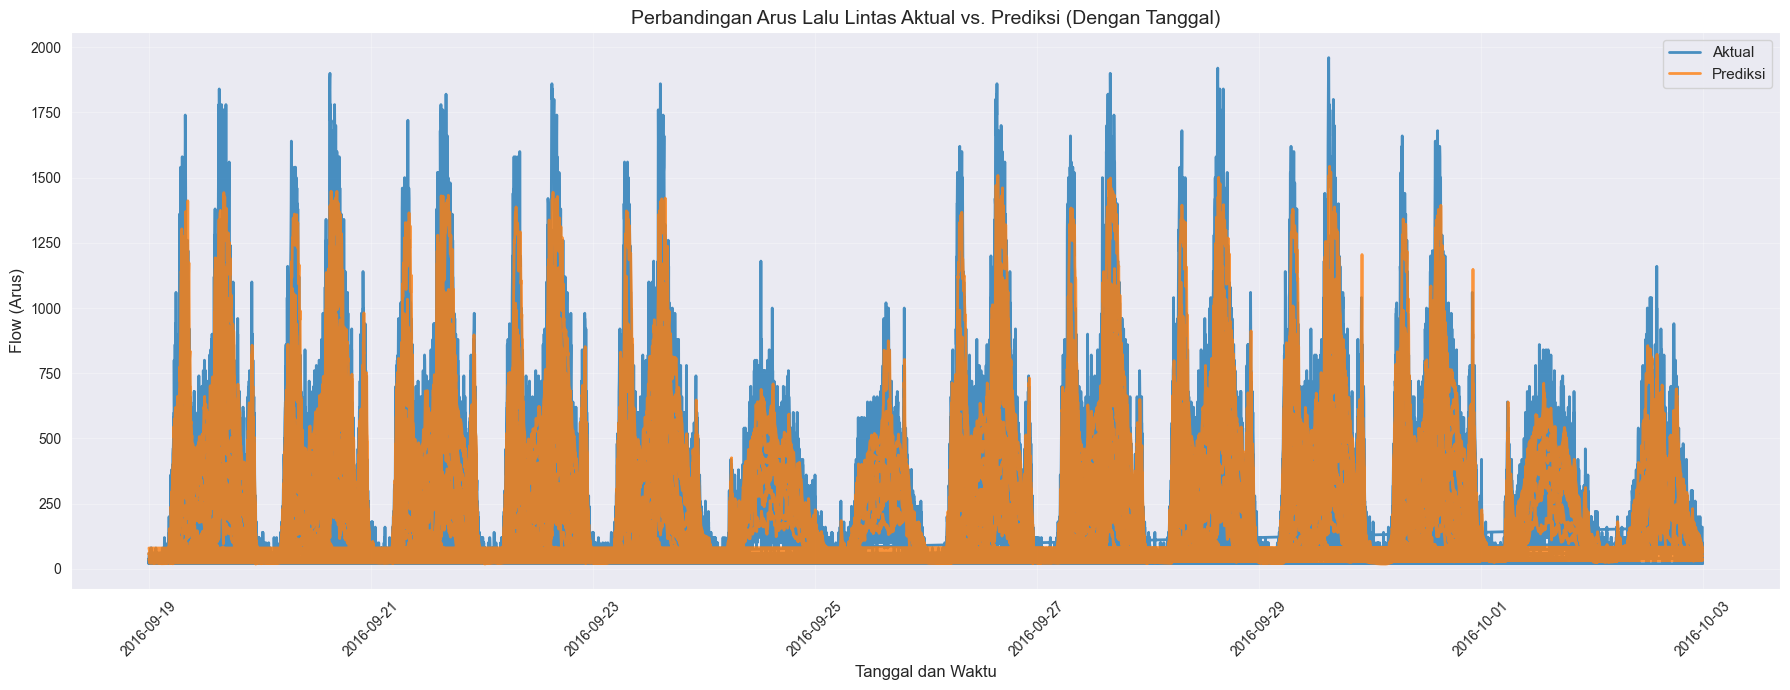

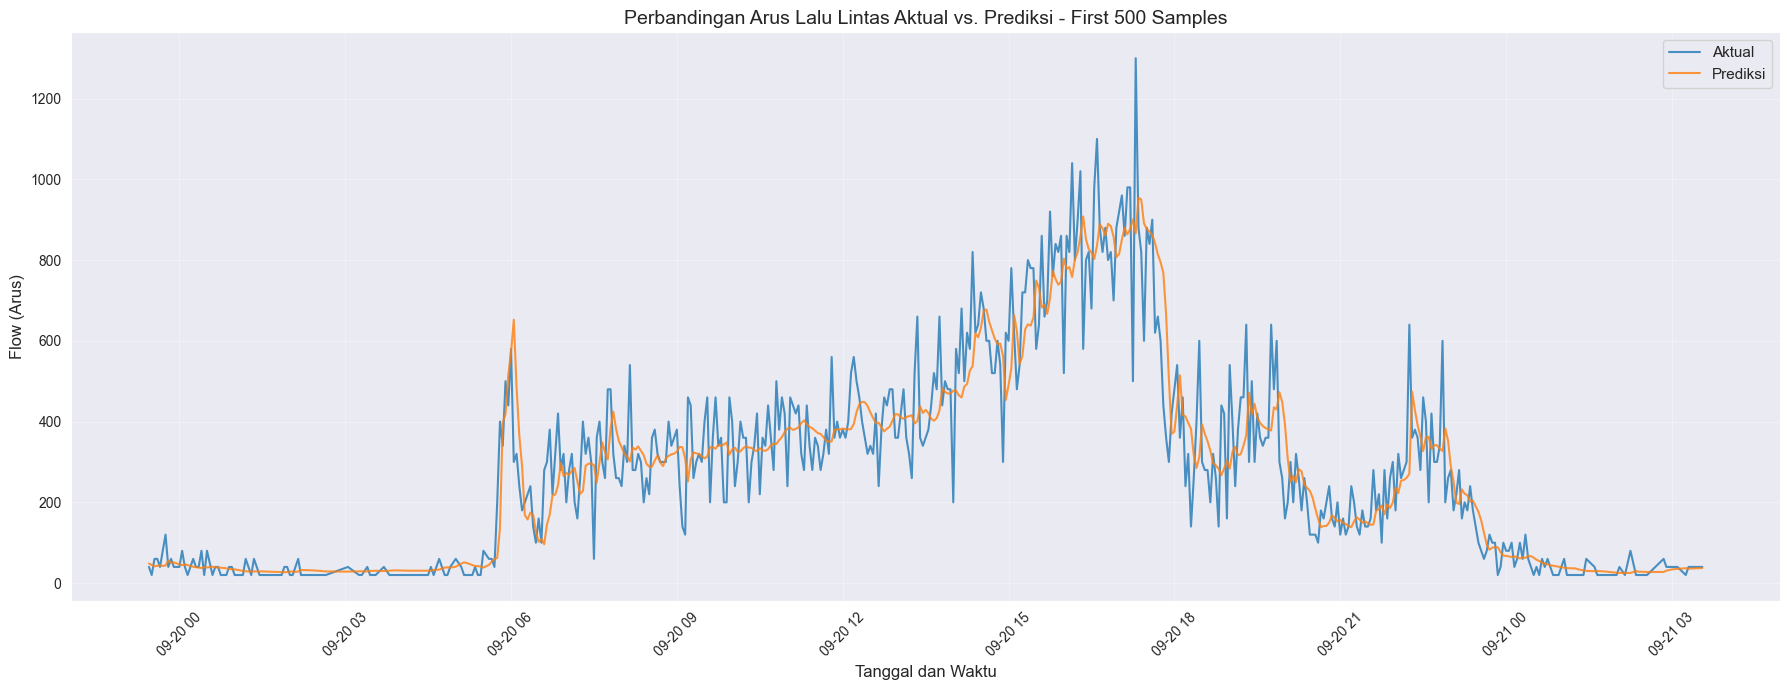

Visualisasi dengan tanggal selesai!


In [42]:
# -------------------------------------------------------------------
# 11. VISUALISASI HASIL DENGAN TANGGAL
# -------------------------------------------------------------------

print("Menampilkan plot hasil prediksi dengan tanggal...")

# Load original dataframe untuk mendapatkan tanggal
df_original = pd.read_csv('wolfsburg_cleansing.csv')
df_original = df_original[['flow', 'occ', 'day', 'interval']].dropna()

# Buat datetime dari day dan interval
df_original['datetime'] = pd.to_datetime(df_original['day']) + pd.to_timedelta(df_original['interval'], unit='s')

# Ambil tanggal yang sesuai dengan test set (dari split point)
test_start_idx = len(X_train) + SEQ_LENGTH
test_dates = df_original['datetime'].iloc[test_start_idx:test_start_idx + len(y_test_original)].values

# Gabungkan hasil untuk plotting dengan tanggal
hasil_plot = pd.DataFrame({
    'Aktual': y_test_original.flatten(),
    'Prediksi': y_pred_original.flatten()
}, index=test_dates)

# Plot dengan tanggal sebagai x-axis
plt.figure(figsize=(18, 7))
plt.plot(hasil_plot.index, hasil_plot['Aktual'], label='Aktual', linewidth=2, alpha=0.8)
plt.plot(hasil_plot.index, hasil_plot['Prediksi'], label='Prediksi', linewidth=2, alpha=0.8)
plt.title('Perbandingan Arus Lalu Lintas Aktual vs. Prediksi (Dengan Tanggal)', fontsize=14)
plt.xlabel('Tanggal dan Waktu', fontsize=12)
plt.ylabel('Flow (Arus)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot untuk first 500 samples
plt.figure(figsize=(18, 7))
hasil_plot_head = hasil_plot.head(500)
plt.plot(hasil_plot_head.index, hasil_plot_head['Aktual'], label='Aktual', linewidth=1.5, alpha=0.8)
plt.plot(hasil_plot_head.index, hasil_plot_head['Prediksi'], label='Prediksi', linewidth=1.5, alpha=0.8)
plt.title('Perbandingan Arus Lalu Lintas Aktual vs. Prediksi - First 500 Samples', fontsize=14)
plt.xlabel('Tanggal dan Waktu', fontsize=12)
plt.ylabel('Flow (Arus)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Visualisasi dengan tanggal selesai!")


PREDIKSI UNTUK 3 HARI KE DEPAN
Melakukan prediksi untuk 480 langkah ke depan...
Prediksi untuk 3 hari selesai! Total prediksi: 480
Tanggal terakhir data historis: 2016-10-02 23:57:00
Prediksi untuk 3 hari selesai! Total prediksi: 480
Tanggal terakhir data historis: 2016-10-02 23:57:00


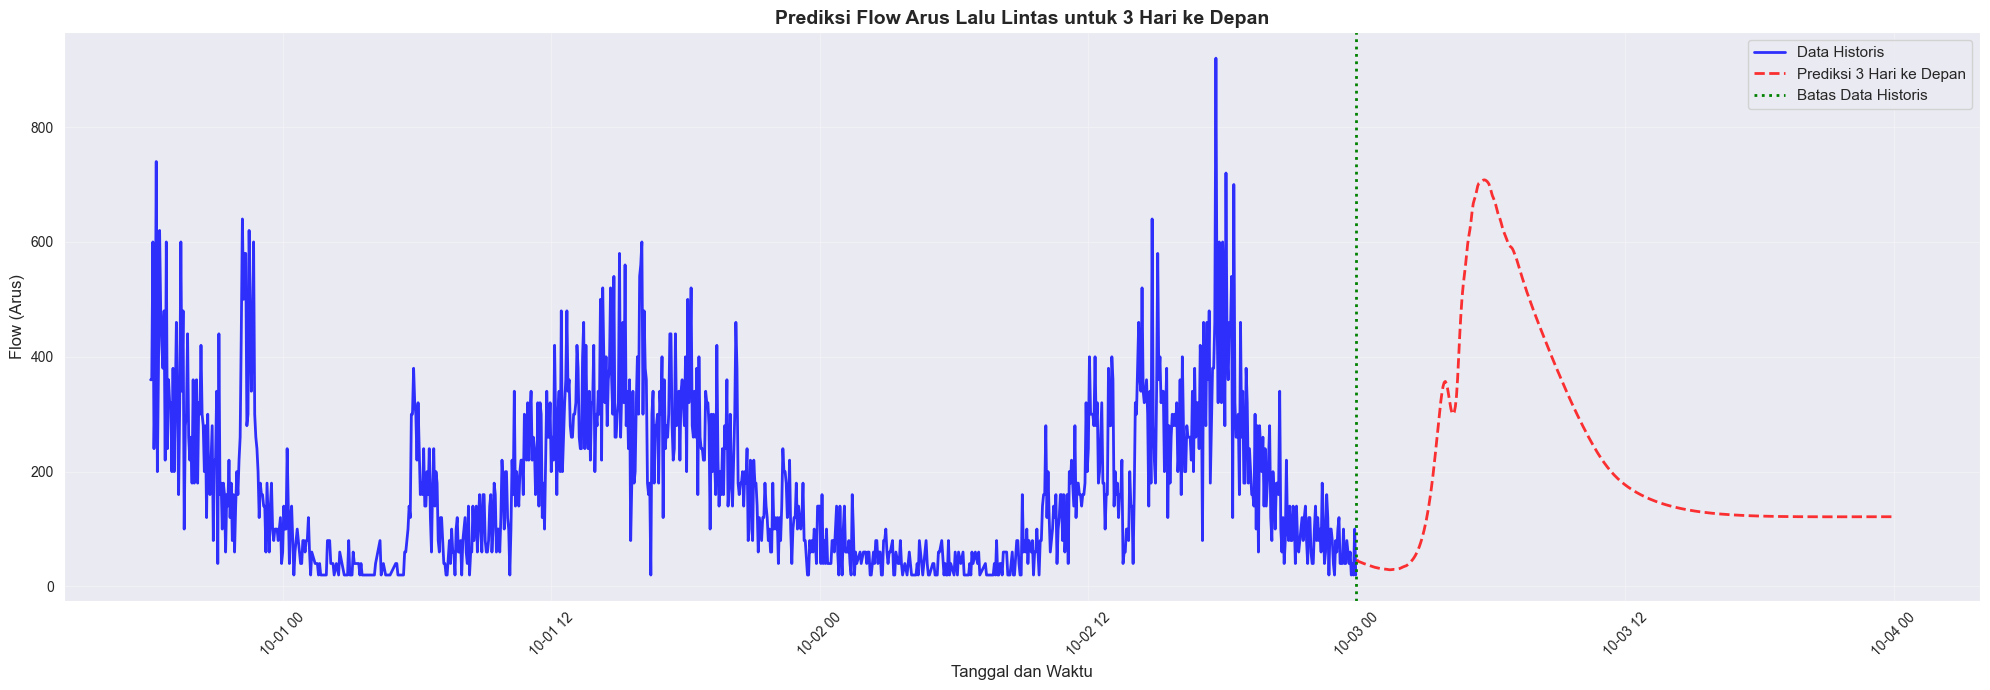


--- Statistik Prediksi 3 Hari ke Depan ---
Nilai minimum prediksi: 29.14
Nilai maksimum prediksi: 708.07
Nilai rata-rata prediksi: 223.26
Standar deviasi prediksi: 181.69

Tanggal awal prediksi: 2016-10-03 00:00:00
Tanggal akhir prediksi: 2016-10-03 23:57:00
Durasi prediksi: 0 hari



In [43]:
# -------------------------------------------------------------------
# 12. PREDIKSI UNTUK 3 HARI KE DEPAN
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("PREDIKSI UNTUK 3 HARI KE DEPAN")
print("=" * 70)

# Ambil data terakhir untuk sequence berikutnya
last_data_point = scaled_data[-SEQ_LENGTH:]  # 48 data points terakhir

# Inisialisasi variabel untuk prediksi
future_predictions_scaled = []
current_sequence = last_data_point.copy()

# Jumlah prediksi untuk 3 hari (asumsikan data 3-menit interval)
# 3 hari = 72 jam = 4320 menit = 1440 data points (untuk interval 3 menit)
num_future_steps = 480  # 480 * 3 menit = 1440 menit = 1 hari, jadi 480 * 3 = 1440 untuk 3 hari

print(f"Melakukan prediksi untuk {num_future_steps} langkah ke depan...")

# Model dalam mode evaluasi
model.eval()

with torch.no_grad():
    for i in range(num_future_steps):
        # Convert sequence to tensor dan move ke device
        x_input = torch.tensor(current_sequence.reshape(1, SEQ_LENGTH, 1), dtype=torch.float32).to(device)
        
        # Prediksi
        y_pred = model(x_input).cpu().numpy()
        
        # Tambahkan prediksi ke list
        future_predictions_scaled.append(y_pred[0, 0])
        
        # Update sequence dengan menghapus elemen pertama dan menambahkan prediksi
        current_sequence = np.vstack([current_sequence[1:], y_pred])

# Convert scaled predictions ke original scale
future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions_original = scaler.inverse_transform(future_predictions_scaled)

print(f"Prediksi untuk 3 hari selesai! Total prediksi: {len(future_predictions_original)}")

# Ambil tanggal terakhir dan buat tanggal untuk prediksi
last_date = df_original['datetime'].iloc[-1]
print(f"Tanggal terakhir data historis: {last_date}")

# Buat tanggal untuk prediksi (dengan interval 3 menit)
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(minutes=3),
    periods=num_future_steps,
    freq='3T'  # 3 menit interval
)

# Gabungkan dengan data historis untuk visualisasi
historical_data = pd.DataFrame({
    'datetime': df_original['datetime'].iloc[-1000:],  # Last 1000 points
    'flow': df_original['flow'].iloc[-1000:].values
})

future_data = pd.DataFrame({
    'datetime': future_dates,
    'flow': future_predictions_original.flatten()
})

# Plot historis + prediksi 3 hari
plt.figure(figsize=(20, 7))
plt.plot(historical_data['datetime'], historical_data['flow'], 
         label='Data Historis', linewidth=2, color='blue', alpha=0.8)
plt.plot(future_data['datetime'], future_data['flow'], 
         label='Prediksi 3 Hari ke Depan', linewidth=2, color='red', linestyle='--', alpha=0.8)

# Tambahkan garis vertikal di titik transisi
plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Batas Data Historis')

plt.title('Prediksi Flow Arus Lalu Lintas untuk 3 Hari ke Depan', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal dan Waktu', fontsize=12)
plt.ylabel('Flow (Arus)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistik prediksi
print(f"\n--- Statistik Prediksi 3 Hari ke Depan ---")
print(f"Nilai minimum prediksi: {future_predictions_original.min():.2f}")
print(f"Nilai maksimum prediksi: {future_predictions_original.max():.2f}")
print(f"Nilai rata-rata prediksi: {future_predictions_original.mean():.2f}")
print(f"Standar deviasi prediksi: {future_predictions_original.std():.2f}")
print(f"\nTanggal awal prediksi: {future_dates[0]}")
print(f"Tanggal akhir prediksi: {future_dates[-1]}")
print(f"Durasi prediksi: {(future_dates[-1] - future_dates[0]).days} hari")

print("\n" + "=" * 70)

In [44]:
# -------------------------------------------------------------------
# 10. SAVE MODEL (OPTIONAL)
# -------------------------------------------------------------------

print("\n" + "=" * 70)
print("MENYIMPAN MODEL")
print("=" * 70)

# Save PyTorch model
model_path = 'lstm_best_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel tersimpan di: {model_path}")

# Save HDF5 format (jika menggunakan torch dengan h5)
# Alternatif: simpan entire model
model_path_full = 'lstm_model_full.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_min': scaler.data_min_,
    'scaler_scale': scaler.scale_,
    'seq_length': SEQ_LENGTH,
    'target_col': target_col
}, model_path_full)
print(f"Model lengkap (dengan scaler) tersimpan di: {model_path_full}")

print("\n" + "=" * 70)
print("RINGKASAN HASIL TRAINING")
print("=" * 70)
print(f"\nDataset: {df.shape[0]} samples, Target column: {target_col}")
print(f"Sequence length: {SEQ_LENGTH}")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"\nModel Configuration:")
print(f"  - Architecture: 2-layer LSTM (50 hidden units) + Linear")
print(f"  - Optimizer: Adam (lr=0.001)")
print(f"  - Loss: MSE")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Device: {device}")
print(f"\nFinal Performance Metrics:")
print(f"  - MAE: {mae:.4f}")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - Final Train Loss: {train_losses[-1]:.6f}")
print(f"  - Final Test Loss: {test_losses[-1]:.6f}")
print("\n" + "=" * 70)


MENYIMPAN MODEL

Model tersimpan di: lstm_best_model.pth
Model lengkap (dengan scaler) tersimpan di: lstm_model_full.pth

RINGKASAN HASIL TRAINING

Dataset: 522588 samples, Target column: flow
Sequence length: 48
Training samples: 418032, Test samples: 104508

Model Configuration:
  - Architecture: 2-layer LSTM (50 hidden units) + Linear
  - Optimizer: Adam (lr=0.001)
  - Loss: MSE
  - Epochs: 200
  - Batch size: 64
  - Device: cuda

Final Performance Metrics:
  - MAE: 69.2899
  - RMSE: 103.0926
  - Final Train Loss: 0.002137
  - Final Test Loss: 0.002824

